<a href="https://www.kaggle.com/code/tofunmiah/interpretive-multiplicity-disaster-tweets?scriptVersionId=103192972" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Experiments for paper “Not all models explain the same”: Measuring Interpretive Multiplicity between Black Box Predictors by Adigun-Hameed & Binns
# Imports 

In [1]:
# Import libraries
import scipy.stats
import numpy as np
import pandas as pd
import random
random.seed(777)

import seaborn as sns


import shap

import string
import re

from wordcloud import STOPWORDS
import category_encoders as ce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.feature_selection import RFECV


In [2]:
#find out versions
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

shap==0.40.0
seaborn==0.11.2
scipy==1.7.1
scikit-learn==0.23.2
pandas==1.3.3
numpy==1.19.5


In [3]:
raw_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
raw_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
raw_test.shape
# raw_test.head()

(3263, 4)

# Data Pre-processing

In [5]:
def clean_loc(x,top_loc):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'

In [6]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

def process_text(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    return df

def create_stat(df):
    # Tweet length
    df['text_len'] = df['text_clean'].apply(len)
    # Word count
    df['word_count'] = df["text_clean"].apply(lambda x: len(str(x).split()))
    # Stopword count
    df['stop_word_count'] = df['text_clean'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
    # Punctuation count
    df['punctuation_count'] = df['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    # Count of hashtags (#)
    df['hashtag_count'] = df['hashtags'].apply(lambda x: len(str(x).split()))
    # Count of mentions (@)
    df['mention_count'] = df['mentions'].apply(lambda x: len(str(x).split()))
    # Count of links
    df['link_count'] = df['links'].apply(lambda x: len(str(x).split()))
    # Count of uppercase letters
    df['caps_count'] = df['text_clean'].apply(lambda x: sum(1 for c in str(x) if c.isupper()))
    # Ratio of uppercase letters
    df['caps_ratio'] = df['caps_count'] / df['text_len']
    return df

def count_vectorize(vectorizer,feature, data, fit_trans = True):
    feat_vec = vectorizer.fit_transform(data[feature]) if fit_trans else vectorizer.transform(data[feature])
    X_train_feat = pd.DataFrame(feat_vec.toarray(), columns=vectorizer.get_feature_names())
    return X_train_feat


In [7]:
def prep_data(data,test):
    data = data.drop_duplicates().reset_index(drop=True)
    for col in ['keyword','location']:
        data[col] = data[col].fillna('None')
        test[col] = test[col].fillna('None')
    raw_loc = data.location.value_counts()
    top_loc = list(raw_loc[raw_loc>=10].index)
    data['location_clean'] = data['location'].apply(lambda x: clean_loc(str(x),top_loc))
    test['location_clean'] = test['location'].apply(lambda x: clean_loc(str(x),top_loc))
    
    data = process_text(data)
    test = process_text(test)
    data = create_stat(data)
    test = create_stat(test)
    
    features = ['keyword', 'location_clean']
    encoder = ce.TargetEncoder(cols=features)
    encoder.fit(data[features],data['target'])
    data = data.join(encoder.transform(data[features]).add_suffix('_target'))
    test = test.join(encoder.transform(test[features]).add_suffix('_target'))    
    vec_links = CountVectorizer(min_df = 5, analyzer = 'word', token_pattern = r'https?://\S+') # Only include those >=5 occurrences
    X_data_link = count_vectorize(vec_links,'links',data)
    X_test_link = count_vectorize(vec_links,'links',test, fit_trans =False)
    
    vec_men = CountVectorizer(min_df = 5)
    X_data_men = count_vectorize(vec_men,'mentions',data)
    X_test_men = count_vectorize(vec_men,'mentions',test, fit_trans =False)

    vec_hash = CountVectorizer(min_df = 5)
    X_data_hash= count_vectorize(vec_hash,'hashtags',data)
    X_test_hash= count_vectorize(vec_hash,'hashtags',test, fit_trans =False)
    vec_text = TfidfVectorizer(min_df = 10, ngram_range = (1,2), stop_words='english') 
    # Only include >=10 occurrences
    # Have unigrams and bigrams
    X_data_text =count_vectorize(vec_text,'text_clean',data)
    X_test_text =count_vectorize(vec_text,'text_clean',test, fit_trans =False)

    # Joining the dataframes together
    data = data.join(X_data_link, rsuffix='_link')
    data = data.join(X_data_men, rsuffix='_mention')
    data = data.join(X_data_hash, rsuffix='_hashtag')
    data = data.join(X_data_text, rsuffix='_text')
    
    test = test.join(X_test_link, rsuffix='_link')
    test = test.join(X_test_men, rsuffix='_mention')
    test = test.join(X_test_hash, rsuffix='_hashtag')
    test = test.join(X_test_text, rsuffix='_text')
    
    features_to_drop = ['id', 'keyword','location','text','location_clean','text_clean', 'hashtags', 'mentions','links']
    data = data.dropna()
    X = data.drop(columns = features_to_drop + ['target'])
    X_test = test.drop(columns = features_to_drop)
    y = data.target
    return X, y, X_test

# Models and performance

The models were submitted to the competition and had the following scores
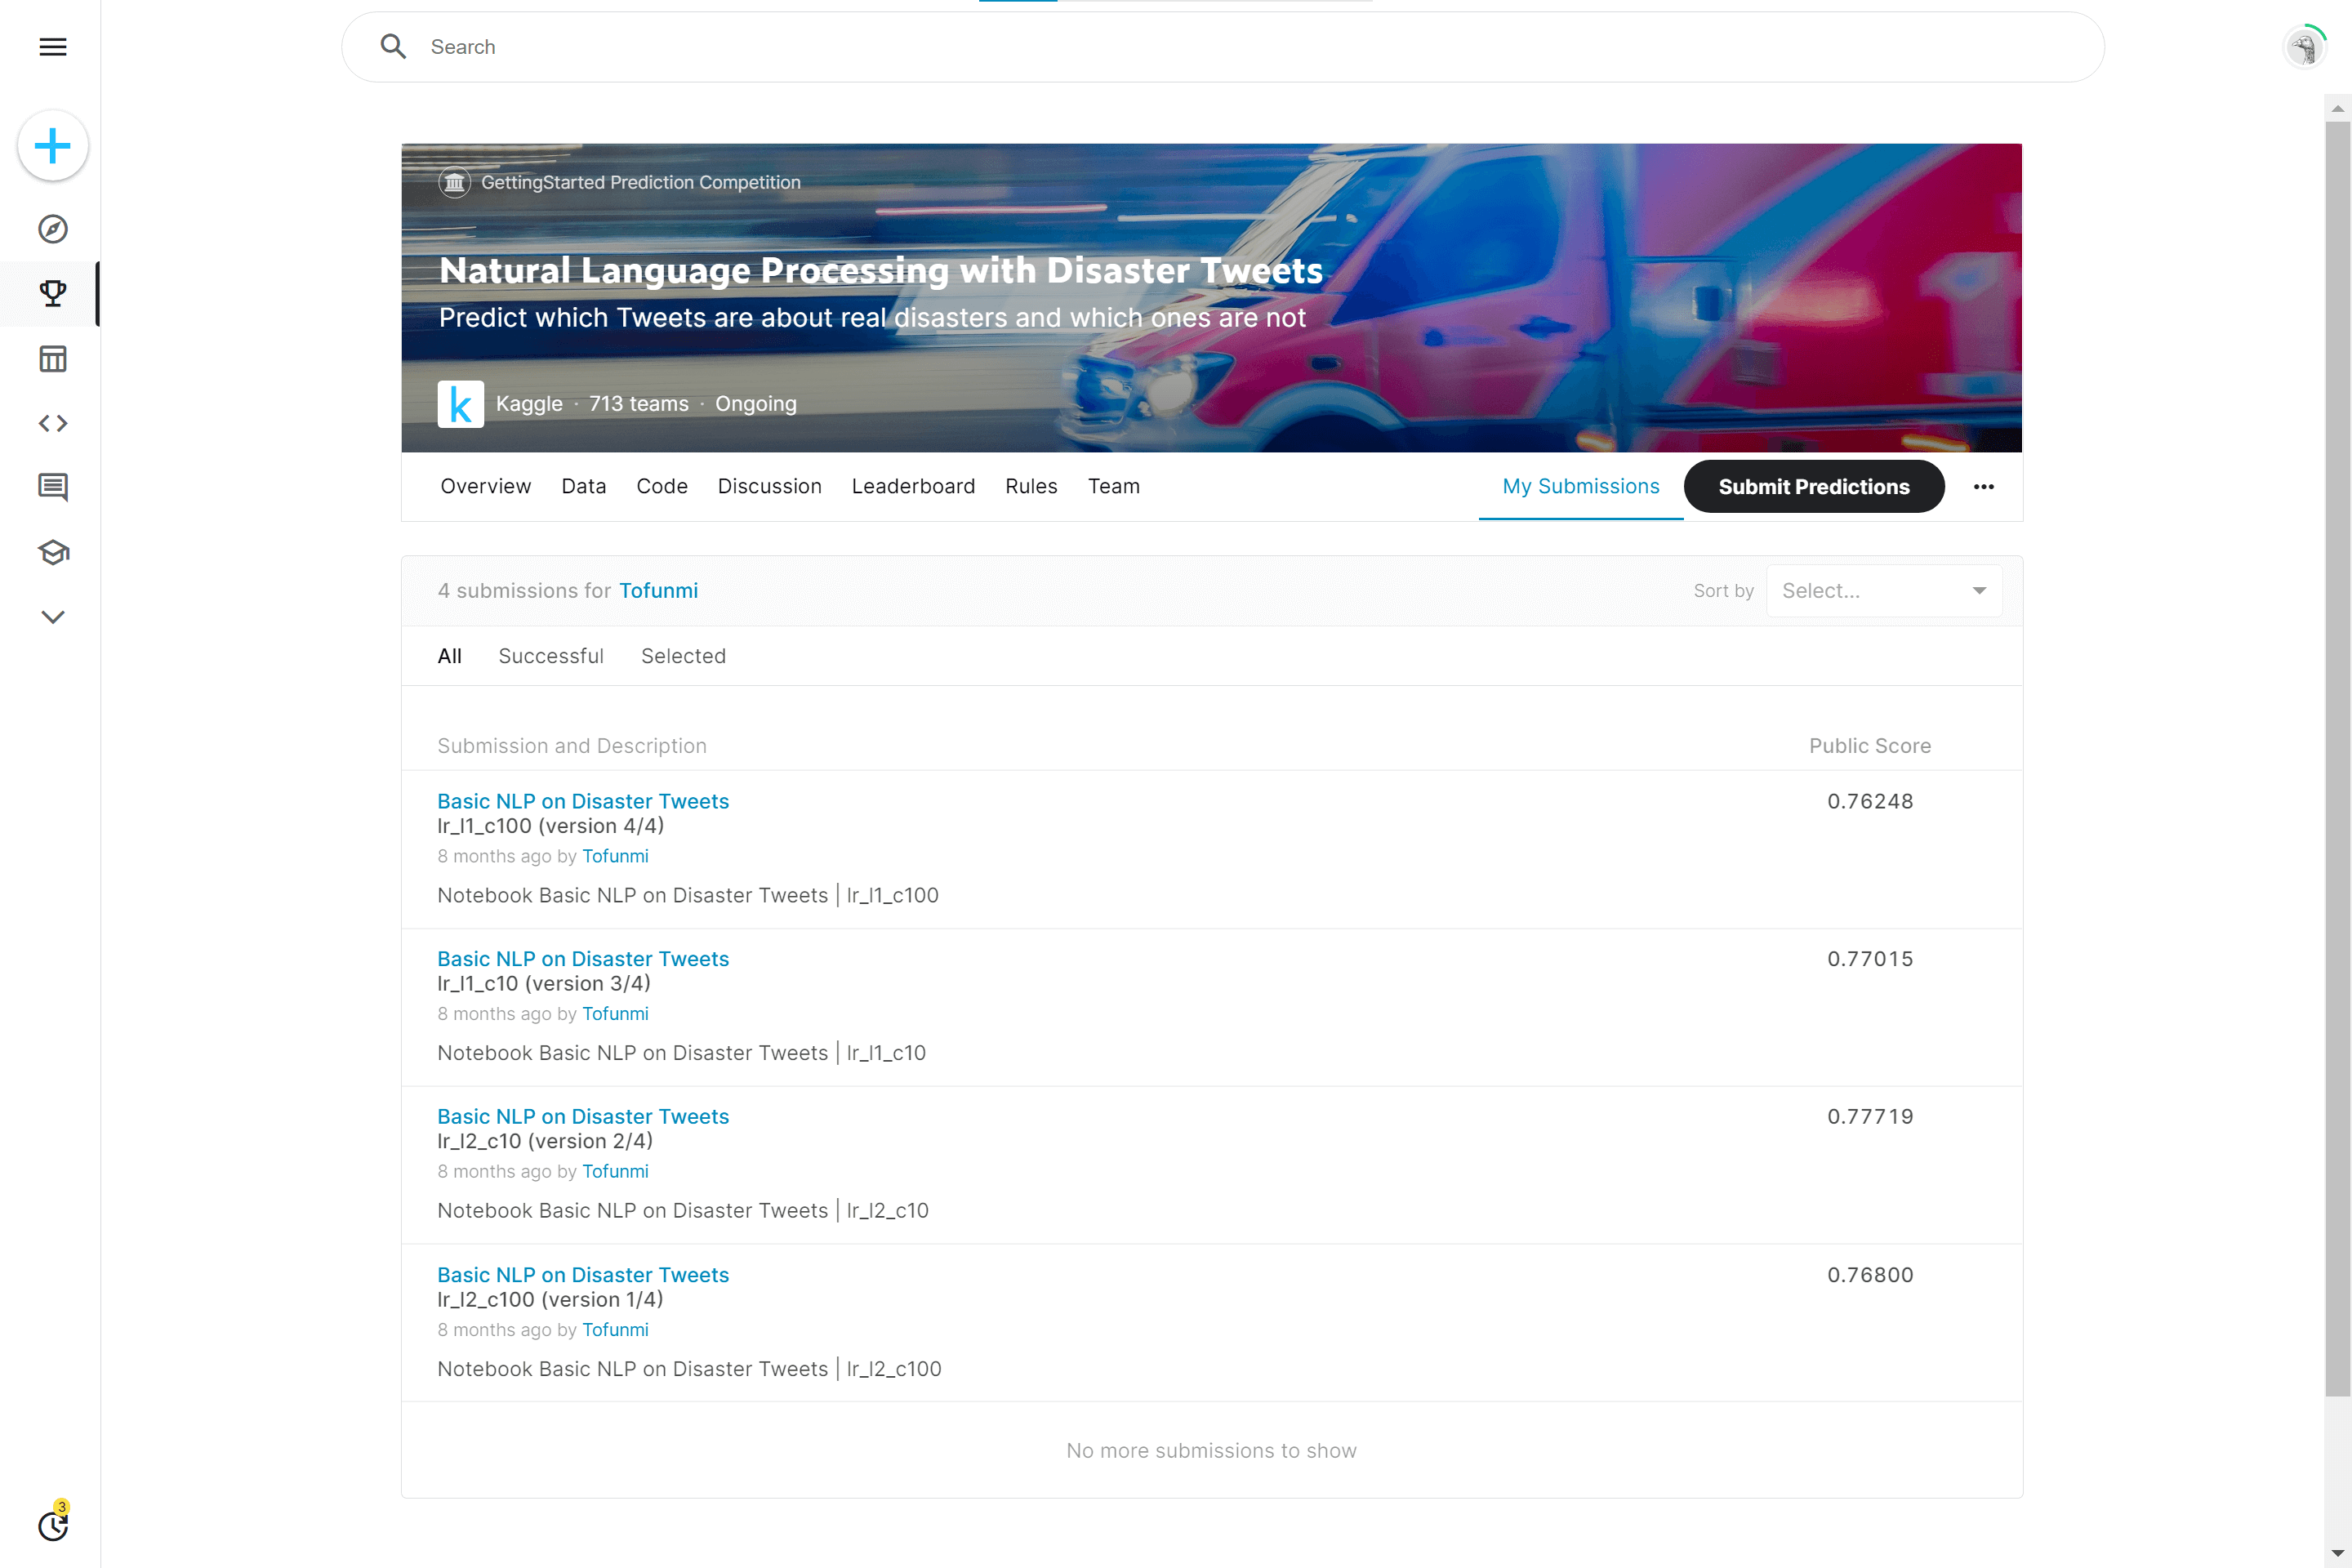

In [8]:
def lr_model(X_train, y_train, penalty='l2',C=1.0):
    scaler = MinMaxScaler()
    lr = LogisticRegression(solver='liblinear', random_state=777, penalty=penalty, C=C) 
    pipeline = Pipeline([('scale',scaler), ('lr', lr),])
    pipeline.fit(X_train, y_train)
    return pipeline

In [9]:
X_train,y_train,X_test = prep_data(raw_train,raw_test)

In [10]:
X_train.shape, X_test.shape, y_train.shape

((7613, 1833), (3263, 1833), (7613,))

In [11]:
all(X_train.columns == X_test.columns)

True

In [12]:
!git clone https://github.com/mitramir55/Kaggle_NLP_competition.git
perfection = pd.read_csv('Kaggle_NLP_competition/perfect_submission.csv')

Cloning into 'Kaggle_NLP_competition'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 80
Unpacking objects: 100% (81/81), done.


In [13]:
lr_l2_c100 = lr_model(X_train,y_train, C=100)
lr_l2_c10 = lr_model(X_train,y_train, C=10)
lr_l1_c100 = lr_model(X_train,y_train, penalty='l1', C=100)
lr_l1_c10 = lr_model(X_train,y_train, penalty='l1', C=10)

lr_models = [lr_l2_c100,lr_l2_c10,lr_l1_c100,lr_l1_c10]

In [14]:
for model in lr_models:
    print(model)
    print('Train f-1 score: %.4f' % f1_score(y_train, model.predict(X_train)))
    print('Test f-1 score: %.4f' % f1_score(perfection.target, model.predict(X_test)))
    print("")

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, random_state=777,
                                    solver='liblinear'))])
Train f-1 score: 0.8578
Test f-1 score: 0.7187

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=10, random_state=777,
                                    solver='liblinear'))])
Train f-1 score: 0.8492
Test f-1 score: 0.7266

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, penalty='l1', random_state=777,
                                    solver='liblinear'))])
Train f-1 score: 0.8595
Test f-1 score: 0.7120

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=10, penalty='l1', random_state=777,
                                    solver='liblinear'))])
Train f-1 score: 0.8547
Test f-1 score: 0.7185



# The generalisation hypothesis

In [15]:
raw_add_on = pd.read_csv("/kaggle/input/disaster-tweets/tweets.csv")

In [16]:
y_add_on = raw_add_on.pop("target")
_,_,X_add_on = prep_data(raw_train,raw_add_on)

In [17]:
X_add_on["target"] = y_add_on
X_add_on.dropna(inplace=True)
y_add_on = X_add_on.target
X_add_on.drop(columns=["target"], inplace=True)
X_add_on.shape, y_add_on.shape

((11368, 1833), (11368,))

In [18]:
print(lr_l2_c100, 'Test f-1 score: %.4f' % f1_score(y_add_on, lr_l2_c100.predict(X_add_on)))
print(lr_l1_c10, 'Test f-1 score: %.4f' % f1_score(y_add_on, lr_l1_c10.predict(X_add_on)))
print(lr_l1_c100, 'Test f-1 score: %.4f' % f1_score(y_add_on, lr_l1_c100.predict(X_add_on)))

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, random_state=777,
                                    solver='liblinear'))]) Test f-1 score: 0.4490
Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=10, penalty='l1', random_state=777,
                                    solver='liblinear'))]) Test f-1 score: 0.4534
Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, penalty='l1', random_state=777,
                                    solver='liblinear'))]) Test f-1 score: 0.4468


# Explanations

In [19]:
def lr_shap(X, pipeline,return_exp=False):
    X_scaled = pipeline['scale'].transform(X)
    explainer = shap.Explainer(pipeline['lr'],X_scaled)
    shap_values = explainer.shap_values(X_scaled)
    if not return_exp:
        return shap_values
    else:
        return explainer,shap_values
    

In [20]:
X = pd.concat([X_train,X_test])
X.shape

(10876, 1833)

In [21]:
all_shap_vals = np.empty((len(lr_models), *X.shape))
for i,model in enumerate(lr_models):
    print(i, model)
    all_shap_vals[i] = lr_shap(X, model)

0 Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, random_state=777,
                                    solver='liblinear'))])
1 Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=10, random_state=777,
                                    solver='liblinear'))])
2 Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, penalty='l1', random_state=777,
                                    solver='liblinear'))])
3 Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=10, penalty='l1', random_state=777,
                                    solver='liblinear'))])


## Signed Rank Argeement

In [22]:
def top_features(datapoint_shap_vals, nfeatures=7):
    """gives the indexes of the n features with the biggest absolute shap vals"""
    return np.argpartition(abs(datapoint_shap_vals), -nfeatures)[-nfeatures:]
    

In [23]:
def equal_ranking(feat, top_feats1, top_feats2):
    return list(np.where(top_feats1==feat)[0]) == list(np.where(top_feats2==feat)[0])

In [24]:
def aggregated_sra(k=45, agg=np.mean):
    sra_matrix = np.zeros([len(lr_models),len(lr_models)])
    for i in range(len(lr_models)-1):
        for j in range(i+1,len(lr_models)):
            shap_vals1 = all_shap_vals[i]
            shap_vals2 = all_shap_vals[j]
            ndatapoints = len(shap_vals1)
            model_sras = np.empty([ndatapoints])
            for l in range(ndatapoints):
                # This for loop implements equation 5
                sra = 0
                top_feats1 = top_features(shap_vals1[l], nfeatures=k)
                top_feats2 = top_features(shap_vals2[l], nfeatures=k)
                for feat in top_feats1:
                    if equal_ranking(feat, top_feats1, top_feats2) and shap_vals1[l][feat]*shap_vals2[l][feat]>=0:
                        sra += 1
                sra /= k
                model_sras[l] = sra
            sra_matrix[i, j] = sra_matrix[j,i] =agg(model_sras)
    print(sra_matrix)
    return np.sum(sra_matrix,axis=0) / (len(lr_models)-1)



In [25]:
aggregated_sra()

[[0.         0.08224429 0.05093376 0.10004904]
 [0.08224429 0.         0.04083201 0.11620081]
 [0.05093376 0.04083201 0.         0.04546198]
 [0.10004904 0.11620081 0.04546198 0.        ]]


array([0.07774236, 0.07975903, 0.04574258, 0.08723727])

In [26]:
sra_res = {
    "10": [0.16727351, 0.15010727, 0.13995648, 0.16347309],
    "20": [0.10623084, 0.09238537, 0.08256865, 0.0991541 ],
    "27": [0.09270611, 0.08350701, 0.06242991, 0.09639074],
    "35": [0.0862178 , 0.07985341, 0.05366819, 0.09219426],
}
sra_df = pd.DataFrame(data=sra_res)
sra_df.mean(axis=1)

0    0.113107
1    0.101463
2    0.084656
3    0.112803
dtype: float64

In [27]:
sra_df.std(axis=1)

0    0.037061
1    0.032854
2    0.038802
3    0.033901
dtype: float64

## Similarity and Conflict

In [28]:
def shap_similarity(epsilon=0.01, normalize=True, measure="S"):
    sim_matrix = np.zeros([len(lr_models),len(lr_models)])
    for i in range(len(lr_models)-1):
        for j in range(i+1,len(lr_models)):
            shap_vals1 = all_shap_vals[i]
            shap_vals2 = all_shap_vals[j]
            if measure == "T":
                # Implementation of equation 2
                similarity = np.count_nonzero(np.abs(shap_vals1-shap_vals2) < epsilon) 
                if normalize:
                    similarity /= np.prod(shap_vals1.shape) 
            elif measure == "S_delta":
                # Implementation of equation 1 with ε=δ*D
                similarity = np.count_nonzero(np.sum(np.abs(shap_vals1-shap_vals2),axis=1)<epsilon*shap_vals1.shape[1])
                if normalize:
                    similarity /= shap_vals1.shape[0]
            elif "S":
                # Implementation of equation 1
                similarity = np.count_nonzero(np.max(np.abs(shap_vals1-shap_vals2),axis=1)<epsilon)
                if normalize:
                    similarity /= shap_vals1.shape[0]
            print(str(lr_models[i])[:120],"vs",str(lr_models[j])[:120],similarity, sep="\n", end="\n\n")
            sim_matrix[i,j] = sim_matrix[j, i] = similarity    
    return np.sum(sim_matrix,axis=0) / (len(lr_models)-1)


In [29]:
shap_similarity()

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, random_stat
vs
Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=10, random_state
0.0

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, random_stat
vs
Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, penalty='l1
0.0

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, random_stat
vs
Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=10, penalty='l1'
0.0

Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=10, random_state
vs
Pipeline(steps=[('scale', MinMaxScaler()),
                ('lr',
                 LogisticRegression(C=100, penalty='l1
0.0



array([0., 0., 0., 0.])

#### plots for similarity

In [30]:
delta = [0.001,0.0025,0.005,0.0075,0.01]

In [31]:
l1c100_S_sims = [0.0,0.2493870295451759,0.771024886600466,0.905142822115974,0.9580421723672918]
l2c100_S_sims = [0.0,0.5483633688856197,0.9214784847370358,0.9802317028319235,0.9928895427240407]
l2c10_S_sims  = [0.016488905234767686,0.33014588696824815,0.8304523721956603,0.9351477258796126,0.9720178987372808]
l1c10_S_sims  = [0.016488905234767686,0.5397511339953414,0.913540517347064,0.9721711413509869,0.988414858403825]

S_sims_df = pd.DataFrame({
    "delta": delta,
    "LR_l1_C10": l1c10_S_sims,
    "LR_l1_C100": l1c100_S_sims,
    "LR_l2_C100": l2c100_S_sims,
    "LR_l2_C10": l2c10_S_sims,

})

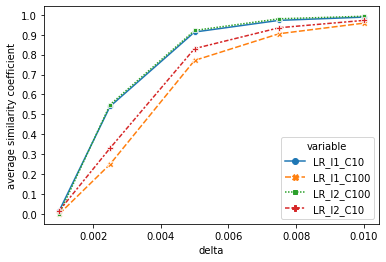

In [32]:
sim_fig = sns.lineplot(x="delta", y="value", hue="variable", style ="variable", markers=True, data=pd.melt(S_sims_df,["delta"]))
sim_fig.set_ylabel("average similarity coefficient")
sim_fig.set_yticks(np.linspace(0,1,11))

In [33]:
l1c100_T_sims = [0.813661379202919,0.8666690944710869,0.9095306605948816,0.9375167245962204,0.9533091576180791]
l2c100_T_sims = [0.8152805675792069,0.8773737723954089,0.9286962034823811,0.9539388819298517,0.966498690022279]
l2c10_T_sims  = [0.814009983158528,0.8667609062759815,0.9102741338974937,0.9400599834895923,0.9560445006517951]
l1c10_T_sims  = [0.8212256954539395,0.8776369684654958,0.9275050243178388,0.9524716152543968,0.967796779527469]

test_T_sims_df = pd.DataFrame({
    "delta": delta,
    "LR_l1_C10": l1c10_T_sims ,
    "LR_l1_C100":l1c100_T_sims,
    "LR_l2_C100":l2c100_T_sims,
    "LR_l2_C10": l2c10_T_sims ,
})

In [34]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="whitegrid")

Text(0, 0.5, 'average similarity coefficient')

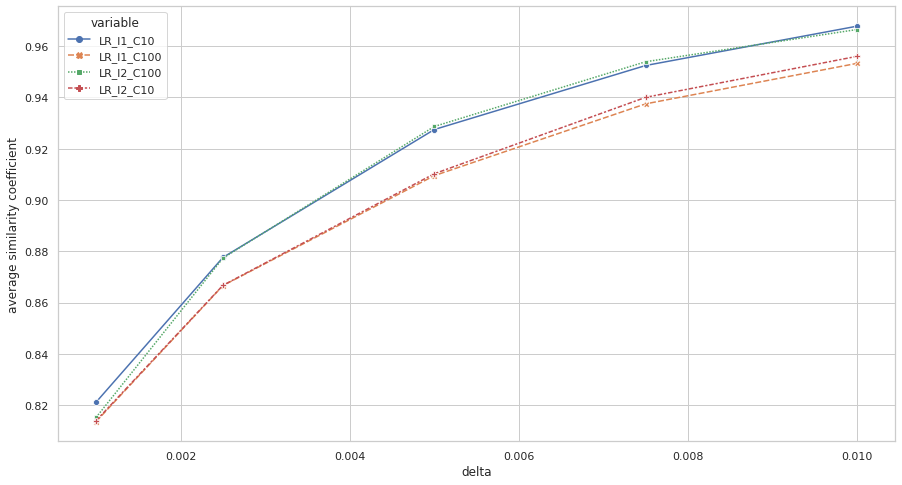

In [35]:
sim_fig = sns.lineplot(x="delta", y="value", hue="variable", style ="variable", markers=True, data=pd.melt(test_T_sims_df,["delta"]))
sim_fig.set_ylabel("average similarity coefficient")

In [36]:
def shap_conflict(X,pipeline1,pipeline2, alpha=2, normalize=True, measure="C"):
    shap_vals1 = lr_shap(X,pipeline1)
    shap_vals2 = lr_shap(X,pipeline2)
    conf_cond = shap_vals1*shap_vals2<0
    dist_cond = np.abs(shap_vals1-shap_vals2) > alpha
    if measure == "C":
        # Implementation on equation 3
        conflict = np.count_nonzero(np.max(np.logical_and(dist_cond, conf_cond), axis=1))
        if normalize:
            conflict /= shap_vals1.shape[0]
    elif measure == "F":
        # Implementation on equation 4
        conflict = np.sum(dist_cond & conf_cond)
        if normalize:
            conflict /= np.prod(shap_vals1.shape) 
    return conflict
    

In [37]:
shap_l1c100_v_l2c10 = shap_conflict(X,lr_l1_c100,lr_l2_c10)

In [38]:
shap_l2c100_v_l1c10 = shap_conflict(X,lr_l2_c100,lr_l1_c10)

shap_l1c100_v_l2c100 = shap_conflict(X,lr_l1_c100,lr_l2_c100)

shap_l1c100_v_l2c10 = shap_conflict(X,lr_l1_c100,lr_l2_c10)

shap_l1c100_v_l1c10 = shap_conflict(X,lr_l1_c100,lr_l1_c10)

shap_l2c100_v_l2c10 = shap_conflict(X,lr_l2_c100,lr_l2_c10)

shap_l2c100_v_l1c10 = shap_conflict(X,lr_l2_c100,lr_l1_c10)

shap_l2c10_v_l1c10 = shap_conflict(X,lr_l2_c10,lr_l1_c10)

In [39]:
print(shap_l1c100_v_l2c100,shap_l1c100_v_l2c10,shap_l1c100_v_l1c10,shap_l2c100_v_l2c10,shap_l2c100_v_l1c10,shap_l2c10_v_l1c10)

0.0 0.011217359323280617 0.0005516734093416697 0.003493931592497242 0.0 0.0006436189775652813


In [40]:
print("lr_l1_c100 conf score", np.mean([shap_l1c100_v_l2c100,shap_l1c100_v_l2c10,shap_l1c100_v_l1c10]))
print("lr_l2_c100 conf score", np.mean([shap_l1c100_v_l2c100,shap_l2c100_v_l2c10,shap_l2c100_v_l1c10,]))
print("lr_l2_c10 conf score", np.mean([shap_l1c100_v_l2c10,shap_l2c100_v_l2c10,shap_l2c10_v_l1c10 ]))
print("lr_l1_c10 conf score", np.mean([shap_l1c100_v_l1c10,shap_l2c10_v_l1c10, shap_l2c100_v_l1c10]))

lr_l1_c100 conf score 0.003923010910874095
lr_l2_c100 conf score 0.0011646438641657474
lr_l2_c10 conf score 0.005118303297781047
lr_l1_c10 conf score 0.0003984307956356504


In [41]:
alpha = [0.33,0.5,0.67,0.83,1]

In [42]:
l1c100_conf = [0.0973090597033223,0.052929998774059094,0.0292693392178497,0.02041191614564178,0.01376118671080054]
l2c100_conf = [0.056975603775898,0.023354174328797352,0.013270810346941277,0.008918720117690326,0.005363491479710678]
l2c10_conf  = [0.12814147358097341,0.06914306730415594,0.04094642638224837,0.02890155694495525,0.01906338114502881]
l1c10_conf  = [0.025407625352458014,0.008183155571901435,0.002942258183155572,0.0018389113644722325,0.0015324261370601936]

C_conf_df = pd.DataFrame({
    "alpha": alpha,
    "LR_l1_C10" : l1c10_conf,
    "LR_l1_C100": l1c100_conf,
    "LR_l2_C100": l2c100_conf,
    "LR_l2_C10" : l2c10_conf ,

})

Text(0, 0.5, 'average conflict coefficient')

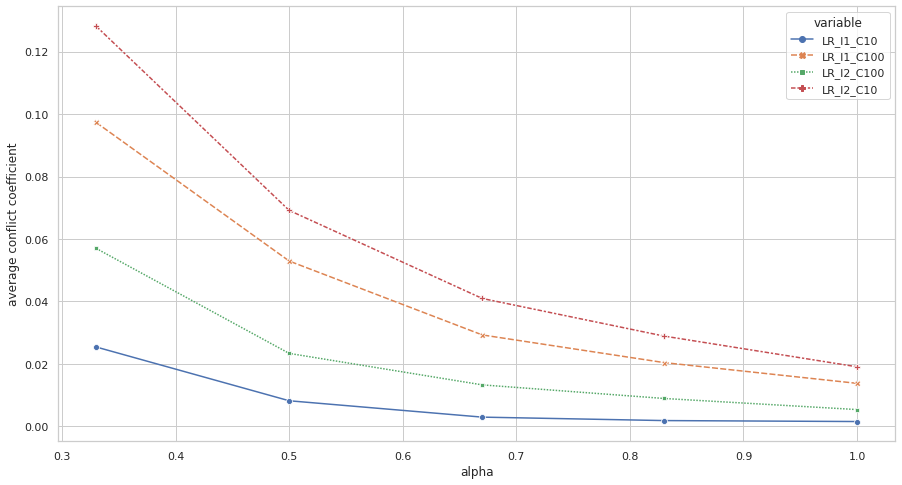

In [43]:
C_conf_fig = sns.lineplot(x="alpha", y="value", hue="variable", style ="variable", markers=True, data=pd.melt(C_conf_df,["alpha"]))
C_conf_fig.set_ylabel("average conflict coefficient")

In [44]:
l1c100_F_conf = [6.042758384435941e-05,3.0514759412273357e-05,1.6804018196895742e-05,1.158724836860572e-05,7.791713910202404e-06]
l2c100_F_conf = [3.394244471611776e-05,1.3292730812469766e-05,7.507466836225063e-06,5.016124834894251e-06,3.0431157331691787e-06]
l2c10_F_conf  = [7.958918071365545e-05,3.9911633269641923e-05,2.3442023395072467e-05,1.6369287377871573e-05,1.0801388811138954e-05]
l1c10_F_conf  = [1.3944827041006015e-05,4.464351103055883e-06,1.60515994716616e-06,1.0032249669788502e-06,8.360208058157085e-07]

F_conf_df = pd.DataFrame({
    "alpha": alpha,
    "LR_l1_C10" : l1c10_F_conf , 
    "LR_l1_C100": l1c100_F_conf, 
    "LR_l2_C100": l2c100_F_conf, 
    "LR_l2_C10" : l2c10_F_conf ,

})

Text(0, 0.5, 'average conflict coefficient')

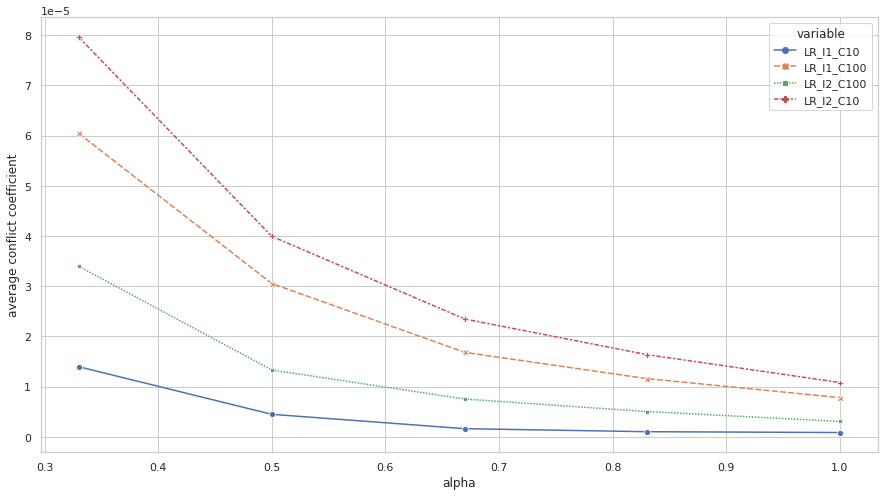

In [45]:
F_conf_fig = sns.lineplot(x="alpha", y="value", hue="variable", style ="variable", markers=True, data=pd.melt(F_conf_df,["alpha"]))
F_conf_fig.set_ylabel("average conflict coefficient")

In [46]:
exp1, shap_vals1 = lr_shap(X,lr_l2_c10,return_exp=True)
exp2, shap_vals2 = lr_shap(X,lr_l1_c100,return_exp=True)
exp3, shap_vals3 = lr_shap(X,lr_l2_c100,return_exp=True)
exp4, shap_vals4 = lr_shap(X,lr_l1_c10,return_exp=True)

## Conflict Examples

In [47]:
shap.initjs()

In [48]:
#One example of Multiplicity
shap_vals1[8591,1185]

-0.730766005123939

In [49]:
shap_vals2[8591,1185]

3.472764099138785

In [50]:
data_indexes = [583,8591,1018,1209]

In [51]:
# change the data index to see the different coflicting datapoints
data_index = data_indexes[0]

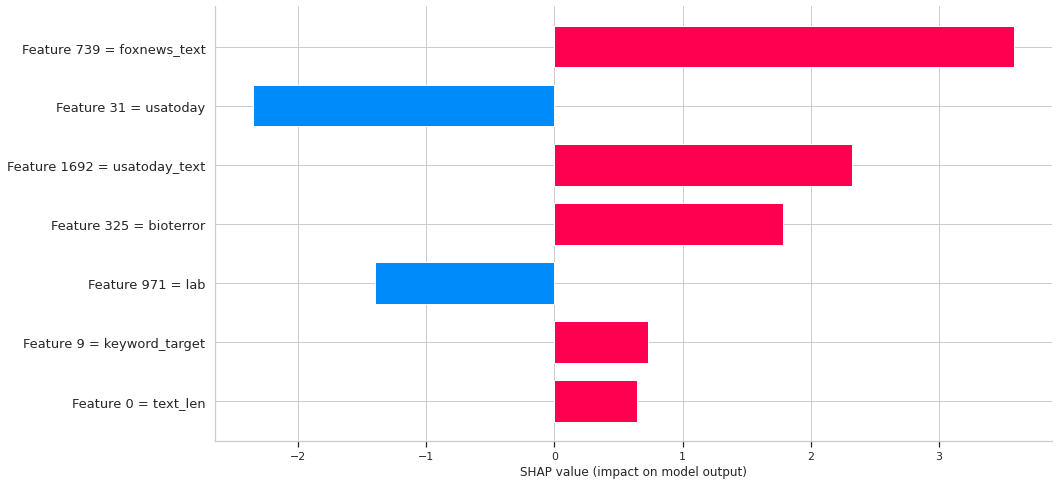

In [52]:
shap.bar_plot(shap_vals4[data_index],X.iloc[[data_index]])

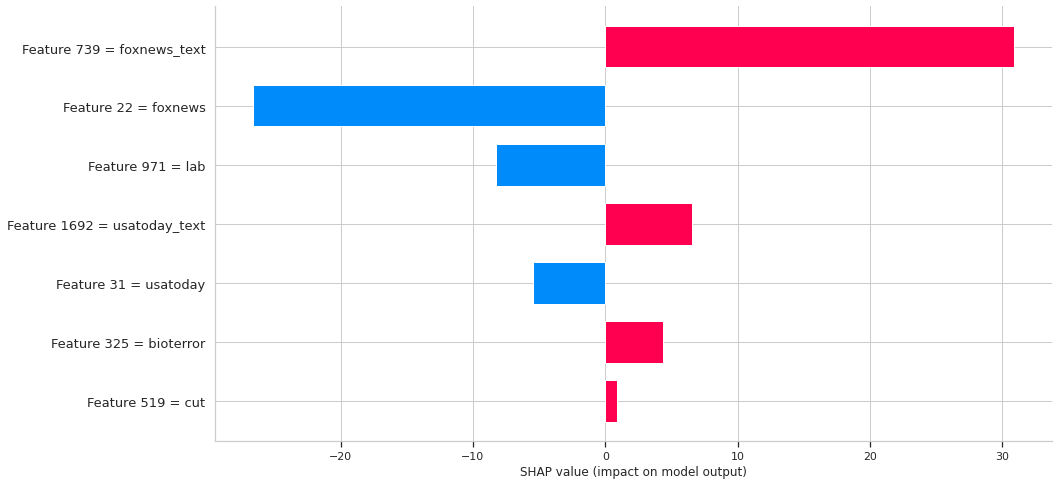

In [53]:
shap.bar_plot(shap_vals2[data_index],X.iloc[[data_index]])

In [54]:
shap.force_plot(exp1.expected_value, shap_vals1[8591],X.iloc[[8591]],link="logit")

In [55]:
shap.force_plot(exp2.expected_value, shap_vals2[8591],X.iloc[[8591]], link="logit")